## 1. Preliminary

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import load_paper_node, load_paper_edge


sns.set_theme()
warnings.filterwarnings("ignore")

## 2. Load and inspect the paper

In [25]:
# Load config file and get the path of csv files
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
base_dir = "data"

PAPER_NODE = Path(base_dir) / config["data"]["paper"]["node"]
PAPER_EDGE = Path(base_dir) / config["data"]["paper"]["edge"]

In [26]:
df_node = load_paper_node(
    PAPER_NODE, False
)  # The NAs in df will not be filled with empty string

2024-12-17 15:03:12 - SocialNetwork - INFO - Load data\paper\node.csv as dataframe, memory usage 946.92 MB
2024-12-17 15:03:12 - SocialNetwork - INFO - Function 'load_paper_node' executed in 10.10 second(s)


In [27]:
df_node.info(verbose=True)
df_node.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680007 entries, 0 to 3680006
Data columns (total 8 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id       string
 1   authors  object
 2   year     Int16 
 3   venue    Int16 
 4   out_d    Int16 
 5   start    Int64 
 6   end      Int64 
 7   in_d     Int16 
dtypes: Int16(4), Int64(2), object(1), string(1)
memory usage: 161.4+ MB


,id,authors,year,venue,out_d,start,end,in_d
0,555036b37cea80f954149ffc,[287837],2015,3833,0,1,1,0
1,555036b37cea80f954149ffd,[855925],2015,3833,0,1,1,0
2,555036b37cea80f954149ffe,"[1714844, 1038326, 1578020, 140095]",2015,3833,0,1,1,0
3,555036b37cea80f954149fff,"[1124727, 1658178]",2015,3833,0,1,1,0
4,555036b37cea80f95414a000,"[407556, 1756780, 1760018, 47850]",2015,3833,0,1,1,0


## 3. Count NaN values

In [28]:
df_node.loc[df_node["year"] == 0, "year"] = np.nan
df_node.loc[df_node["venue"] == 1, "venue"] = np.nan
df_node.loc[df_node["in_d"] == 0, "in_d"] = np.nan
df_node.loc[df_node["out_d"] == 0, "out_d"] = np.nan
nan_counts = df_node.isna().sum()
print(nan_counts)

id               0
authors      52010
year             7
venue        56785
out_d      1906376
start            0
end              0
in_d       3641321
dtype: int64


In [ ]:
# Count the number of nodes that have no connections with other nodes
single_node = df_node[pd.isna(df_node["in_d"]) & pd.isna(df_node["out_d"])]
print(len(single_node))

1875166


## 4. Plot the distribution of list columns

In [30]:
# Handle the NAs in `authors`
df_node["authors"] = df_node["authors"].apply(
    lambda x: x if isinstance(x, list) else []
)

# Calculate the number of authors and references for each row
df_node["num_authors"] = df_node["authors"].apply(len)

# Calculate basic statistics
print(df_node["num_authors"].describe())
print("=" * 20)
print(df_node["out_d"].describe())
print("=" * 20)
print(df_node["in_d"].describe())

count    3.680007e+06
mean     2.836479e+00
std      1.748325e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.390000e+02
Name: num_authors, dtype: float64
count    1773631.0
mean      1.057755
std       1.702516
min            1.0
25%            1.0
50%            1.0
75%            1.0
max          609.0
Name: out_d, dtype: Float64
count      38686.0
mean     48.494727
std      91.343784
min            1.0
25%           14.0
50%           26.0
75%           51.0
max         3067.0
Name: in_d, dtype: Float64


count    3.626640e+06
mean     2.867512e+00
std      1.640951e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: num_authors, dtype: float64


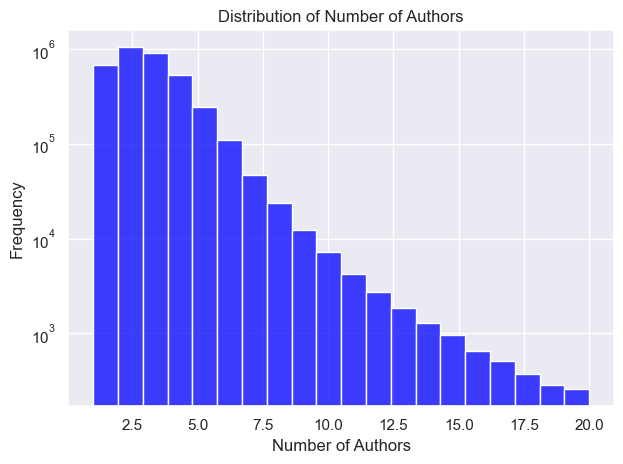

In [31]:
df_filtered_authors = df_node[
    (df_node["num_authors"] > 0) & (df_node["num_authors"] <= 20)
]
print(df_filtered_authors["num_authors"].describe())

# Plot the distribution of the number of authors
sns.histplot(df_filtered_authors["num_authors"], color="blue", bins=20)
plt.title("Distribution of Number of Authors")
plt.xlabel("Number of Authors")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()

count    1773552.0
mean      1.050111
std       1.073527
min            1.0
25%            1.0
50%            1.0
75%            1.0
max           99.0
Name: out_d, dtype: Float64


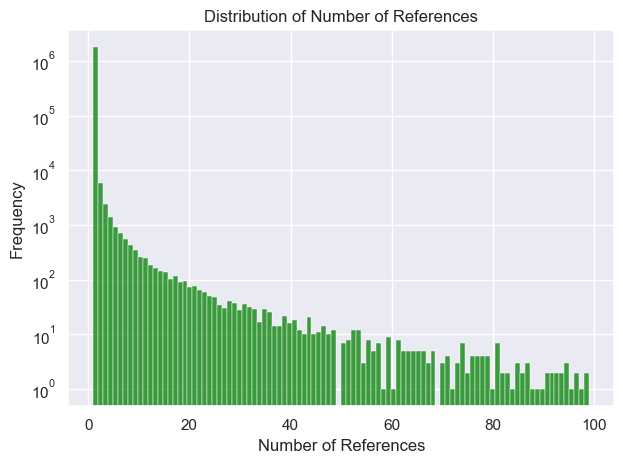

In [32]:
df_filtered_out_d = df_node[(df_node["out_d"] > 0) & (df_node["out_d"] <= 100)]
print(df_filtered_out_d["out_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_out_d["out_d"], color="green", bins=100)
plt.title("Distribution of Number of References")
plt.xlabel("Number of References")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()

count      35162.0
mean     29.818099
std      22.514989
min            1.0
25%           13.0
50%           23.0
75%           41.0
max          100.0
Name: in_d, dtype: Float64


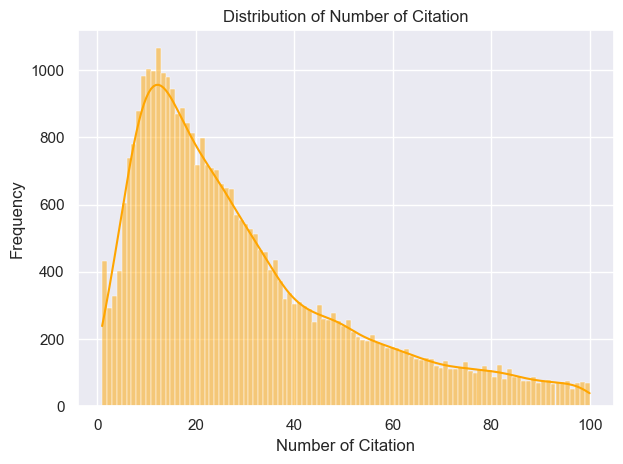

In [33]:
df_filtered_in_d = df_node[(df_node["in_d"] > 0) & (df_node["in_d"] <= 100)]
print(df_filtered_in_d["in_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_in_d["in_d"], color="orange", kde=True, bins=100)
plt.title("Distribution of Number of Citation")
plt.xlabel("Number of Citation")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## 5. Probe other columns

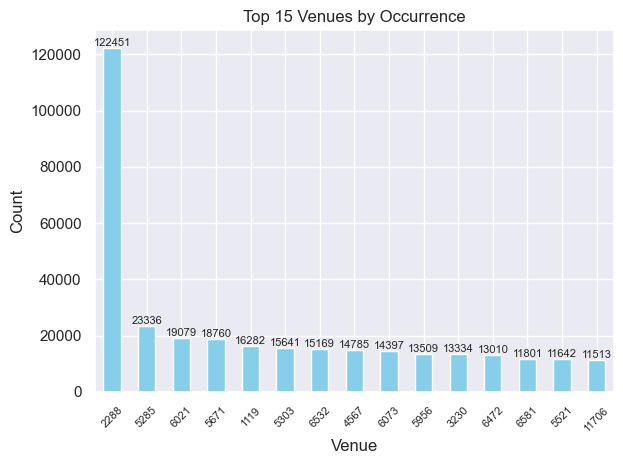

In [34]:
# Get the unique venues and their occurrences
venue_counts = df_node["venue"].value_counts()

# Get the first 15 items
top_15_venues = venue_counts.head(15)

# Plot the first 15 venues
top_15_venues.plot(kind="bar", color="skyblue")
plt.title("Top 15 Venues by Occurrence")
plt.xlabel("Venue")
plt.ylabel("Count")
plt.xticks(rotation=45, fontsize=8)
plt.xticks(rotation=45, fontsize=8)
for i, count in enumerate(top_15_venues):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

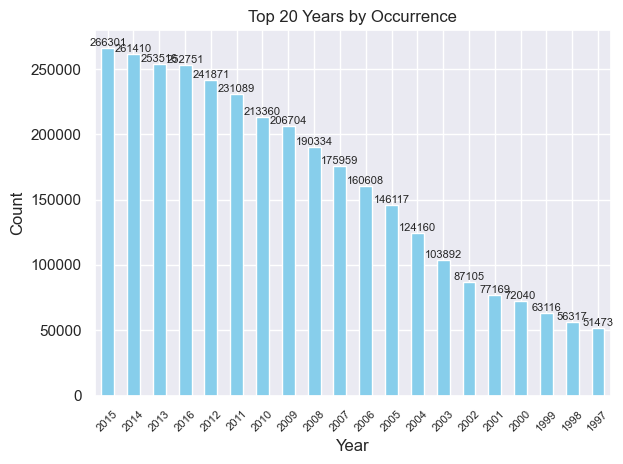

In [35]:
# Get the unique venues and their occurrences
year_counts = df_node["year"].value_counts()

top_20_years = year_counts.head(20)

# Plot the first 20 years
top_20_years.plot(kind="bar", color="skyblue")
plt.title("Top 20 Years by Occurrence")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45, fontsize=8)
for i, count in enumerate(top_20_years):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

## 6. Visualize the edges

2024-12-17 15:03:23 - SocialNetwork - INFO - Load data\paper\edge.csv as dataframe, memory usage 289.84 MB
2024-12-17 15:03:23 - SocialNetwork - INFO - Function 'load_paper_edge' executed in 1.89 second(s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876067 entries, 0 to 1876066
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   src     string
 1   dst     string
dtypes: string(2)
memory usage: 28.6 MB


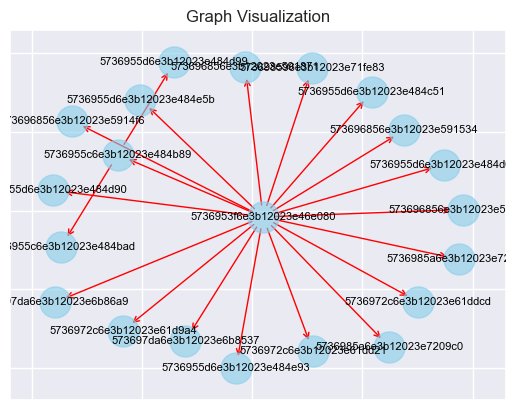

In [36]:
df_edge = load_paper_edge(PAPER_EDGE)
df_edge.info()
# Create a graph using NetworkX
G = nx.from_pandas_edgelist(
    df_edge, source="src", target="dst", create_using=nx.DiGraph()
)

# Get a subset of edges
subgraph_edges = list(G.edges())[:20]
subgraph = G.edge_subgraph(subgraph_edges)
pos = nx.spring_layout(subgraph)

# Plot the graph
nx.draw_networkx_nodes(subgraph, pos, node_size=500, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(
    subgraph, pos, edge_color="red", arrows=True, arrowsize=10, arrowstyle="->"
)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")
plt.title("Graph Visualization")
plt.show()

## 7. Inspect the author node and edges

In [37]:
from utils import load_author_node, load_author_edge

AUTHOR_NODE = base_dir / Path(config["data"]["author"]["node"])
AUTHOR_EDGE = base_dir / Path(config["data"]["author"]["edge"])

df_node = load_author_node(AUTHOR_NODE, False).iloc[2:]
df_edge = load_author_edge(AUTHOR_EDGE)

2024-12-17 15:04:17 - SocialNetwork - INFO - Load data\author\node.csv as dataframe, memory usage 821.52 MB
2024-12-17 15:04:17 - SocialNetwork - INFO - Function 'load_author_node' executed in 42.62 second(s)
2024-12-17 15:04:25 - SocialNetwork - INFO - Load data\author\edge.csv as dataframe, memory usage 1030.36 MB
2024-12-17 15:04:25 - SocialNetwork - INFO - Function 'load_author_edge' executed in 8.26 second(s)


In [38]:
df_node.info(verbose=True)
df_node.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904246 entries, 2 to 1904247
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          int64 
 1   name        string
 2   co-authors  object
 3   papers      object
dtypes: int64(1), object(2), string(1)
memory usage: 58.1+ MB


,id,name,co-authors,papers
2,3,(Max) Zong-Ming Cheng,"[197514, 229313, 319300, 341810, 411771, 54713...","[573695ab6e3b12023e4ca167, 573695ab6e3b12023e4..."
3,4,(Zhou) Bryan Bai,[1580950],"[573696f96e3b12023e5f4f36, 573698766e3b12023e7..."
4,5,A Lun,"[598680, 1813742, 1837042]",[573696f86e3b12023e5f3e82]
5,6,A Min Tjoa,"[21424, 25842, 39524, 65557, 66578, 84768, 847...","[573698846e3b12023e743d45, 573695656e3b12023e4..."
6,7,A'ang Subiyakto,"[22968, 1175140, 1620699]",[58437707ac44360f1082b3ed]


In [39]:
print(df_node.isna().sum())

id                0
name              0
co-authors    94703
papers            0
dtype: int64


count    1.904246e+06
mean     8.805587e+00
std      2.178874e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      3.851000e+03
Name: num_co_authors, dtype: float64


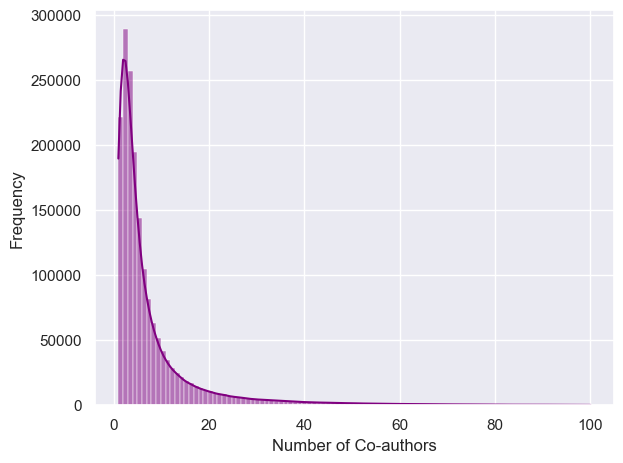

In [40]:
df_node["num_co_authors"] = df_node["co-authors"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)
print(df_node["num_co_authors"].describe())
df_filtered_num_co_authors = df_node[
    (df_node["num_co_authors"] > 0) & (df_node["num_co_authors"] <= 100)
]

sns.histplot(
    df_filtered_num_co_authors["num_co_authors"], color="purple", kde=True, bins=100
)
plt.xlabel("Number of Co-authors")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

count    1.904246e+06
mean     5.481235e+00
std      1.792932e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      2.668000e+03
Name: num_papers, dtype: float64


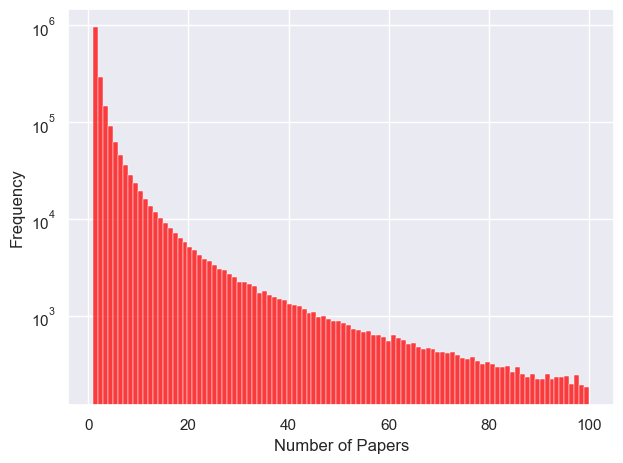

In [41]:
df_node["num_papers"] = df_node["papers"].apply(lambda x: len(x))
print(df_node["num_papers"].describe())
df_filtered_num_papers = df_node[
    (df_node["num_papers"] > 0) & (df_node["num_papers"] <= 100)
]

sns.histplot(df_filtered_num_papers["num_papers"], color="red", bins=100)
plt.xlabel("Number of Papers")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()

In [42]:
# Filter rows where num_papers > 4000
rows_with_large_papers = df_node[
    df_node["papers"].apply(lambda x: len(x) > 100 if isinstance(x, list) else False)
]

# Display the filtered rows
print(len(rows_with_large_papers))

10518


In [43]:
df_edge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384576 entries, 0 to 8384575
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   src     string
 1   dst     string
 2   w       int16 
dtypes: int16(1), string(2)
memory usage: 143.9 MB


 98%|█████████▊| 49/50 [00:04<00:00,  9.96it/s]


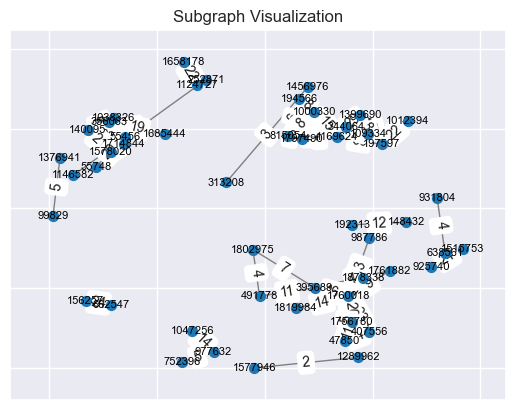

In [44]:
from tqdm import tqdm

# Create a subgraph from the desired edges
subgraph = nx.Graph()
count = 0
for _, row in tqdm(df_edge.iterrows(), total=50):
    subgraph.add_edge(row["src"], row["dst"], weight=row["w"])
    count += 1
    if count == 50:
        break


# Plot the subgraph
pos = nx.spring_layout(subgraph, seed=42, k=1)

nx.draw_networkx_nodes(subgraph, pos, node_size=50)
nx.draw_networkx_edges(subgraph, pos, edge_color="gray")
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(subgraph, "weight")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.title("Subgraph Visualization")
plt.show()